In [1]:
import pandas as pd
import json
from pathlib import Path
import copy
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
results = {f.stem: json.loads(f.read_text()) for f in Path("outputs").glob("*.json")}

In [2]:
def process_log(log:list):
    for record in log:
        if 'action_type' not in record:
            continue
        
        # 去除接收握手和end的消息
        if record['action_type'] == 'recv':
            if 'result' not in record['data']:
                continue
            
            # 提取结果信息
            record['slice_type'] = record['data']['result']['slice_type']
            record['start_time'] = record['data']['result']['start_time']
            record['end_time'] = record['data']['result']['end_time']
            record['voice_text_str'] = record['data']['result']['voice_text_str']
        
        # 删除多余字段
        if 'data' in record:
            del record['data']
            
        # 计算相对时间（相对于当前第一个音频段开始前的信息）
        if 'timestamp' in record:
            record['relative_time']=  (float(record['timestamp']) - float(log[0]['timestamp'])) * 1000
        
        # 计算发送延迟  
        if record['action_type'] == 'sent':
            record['expected_time'] = float(record['chunk_index']) * 40
            record['send_latency'] = float(record['relative_time']) - record['expected_time']
    return pd.DataFrame(log)

def process_logs(logs:dict):
    logs = copy.deepcopy(logs)
    dfs = []
    for k,v in logs.items():
        df = process_log(v)
        df['iid'] = k
        dfs.append(df)
    return dfs

In [3]:
dfs = process_logs(results)

In [4]:
concat_df = pd.concat(dfs)

**日志打点详情**

In [5]:
log_summary = pd.DataFrame(concat_df.groupby(["iid",'action_type','slice_type'], dropna=False).size()).reset_index()
log_summary.columns = ['iid','action_type','slice_type','count']
log_summary

,iid,action_type,slice_type,count
0,1d400c39-51af-4703-ade7-9313fdc19cc7,begin,NaN,1
1,1d400c39-51af-4703-ade7-9313fdc19cc7,end,NaN,1
2,1d400c39-51af-4703-ade7-9313fdc19cc7,recv,0.0,12
3,1d400c39-51af-4703-ade7-9313fdc19cc7,recv,1.0,41
4,1d400c39-51af-4703-ade7-9313fdc19cc7,recv,2.0,12
5,1d400c39-51af-4703-ade7-9313fdc19cc7,recv,NaN,1
6,1d400c39-51af-4703-ade7-9313fdc19cc7,sent,NaN,2429
7,2ea3df4f-b33b-406e-98b3-9eae3b9f62b1,begin,NaN,1
8,2ea3df4f-b33b-406e-98b3-9eae3b9f62b1,end,NaN,1
9,2ea3df4f-b33b-406e-98b3-9eae3b9f62b1,recv,0.0,7


### 发送延迟检查
**计算逻辑：实际发送时间 - 应发送的时间** （send_latency）

In [9]:
pd.set_option("display.max_rows", 500)
concat_df[concat_df.action_type=='sent'].tail(5)

,action_type,timestamp,iid,relative_time,chunk_index,expected_time,send_latency,slice_type,start_time,end_time,voice_text_str,data
1564,sent,42537.941077,2ea3df4f-b33b-406e-98b3-9eae3b9f62b1,61161.451000,1529.0,61160.0,1.451000,NaN,NaN,NaN,NaN,NaN
1565,sent,42537.980949,2ea3df4f-b33b-406e-98b3-9eae3b9f62b1,61201.323292,1530.0,61200.0,1.323292,NaN,NaN,NaN,NaN,NaN
1566,sent,42538.020953,2ea3df4f-b33b-406e-98b3-9eae3b9f62b1,61241.327042,1531.0,61240.0,1.327042,NaN,NaN,NaN,NaN,NaN
1567,sent,42538.060886,2ea3df4f-b33b-406e-98b3-9eae3b9f62b1,61281.260333,1532.0,61280.0,1.260333,NaN,NaN,NaN,NaN,NaN
1568,sent,42538.100873,2ea3df4f-b33b-406e-98b3-9eae3b9f62b1,61321.247542,1533.0,61320.0,1.247542,NaN,NaN,NaN,NaN,NaN


In [128]:
pd.DataFrame(pd.DataFrame.describe(concat_df[concat_df.action_type=='sent']['send_latency']).T)

,send_latency
count,8346.000000
mean,1.343138
std,0.323780
min,0.133542
25%,1.194594
50%,1.349146
75%,1.534407
max,13.429625


In [129]:
import numpy as np
send_p99 = np.percentile(concat_df[concat_df.action_type=='sent']['send_latency'], 99)
print(f"Send latency p99: {send_p99:.2f} ms")

Send latency p99: 1.95 ms


音频chunk的发送时间均在应发送时间之后，最长延迟13ms，99%分位数2ms以下，说明当前发送几乎没有延迟

**非稳态数据记录**

In [125]:
concat_df[(concat_df.action_type=='recv') & (concat_df.slice_type==1)].head(10)

,action_type,timestamp,iid,relative_time,chunk_index,expected_time,send_latency,slice_type,start_time,end_time,voice_text_str,data
94,recv,42542.078949,8d1f8690-0eef-4a40-83ea-9a9d7e232290,3718.837916,NaN,NaN,NaN,1.0,2820.0,3540.0,嗯,NaN
411,recv,42554.639451,8d1f8690-0eef-4a40-83ea-9a9d7e232290,16279.340041,NaN,NaN,NaN,1.0,15300.0,16100.0,对,NaN
419,recv,42554.893423,8d1f8690-0eef-4a40-83ea-9a9d7e232290,16533.311666,NaN,NaN,NaN,1.0,15300.0,16340.0,对我,NaN
432,recv,42555.375957,8d1f8690-0eef-4a40-83ea-9a9d7e232290,17015.846291,NaN,NaN,NaN,1.0,15300.0,16820.0,对我是,NaN
614,recv,42562.558939,8d1f8690-0eef-4a40-83ea-9a9d7e232290,24198.828375,NaN,NaN,NaN,1.0,23220.0,24020.0,那,NaN
623,recv,42562.843655,8d1f8690-0eef-4a40-83ea-9a9d7e232290,24483.544375,NaN,NaN,NaN,1.0,23220.0,24260.0,那我有,NaN
635,recv,42563.297581,8d1f8690-0eef-4a40-83ea-9a9d7e232290,24937.470500,NaN,NaN,NaN,1.0,23220.0,24740.0,那我有自取,NaN
648,recv,42563.776289,8d1f8690-0eef-4a40-83ea-9a9d7e232290,25416.178583,NaN,NaN,NaN,1.0,23220.0,25220.0,那我有罪起床,NaN
661,recv,42564.257764,8d1f8690-0eef-4a40-83ea-9a9d7e232290,25897.652750,NaN,NaN,NaN,1.0,23220.0,25700.0,那我有罪起床你,NaN
668,recv,42564.501795,8d1f8690-0eef-4a40-83ea-9a9d7e232290,26141.684041,NaN,NaN,NaN,1.0,23220.0,25940.0,对我有资金需求,NaN


**稳态数据记录**

In [127]:
concat_df[(concat_df.action_type=='recv') & (concat_df.slice_type==2)].head(10)

,action_type,timestamp,iid,relative_time,chunk_index,expected_time,send_latency,slice_type,start_time,end_time,voice_text_str,data
126,recv,42543.318012,8d1f8690-0eef-4a40-83ea-9a9d7e232290,4957.901583,NaN,NaN,NaN,2.0,2820.0,4700.0,嗯。,NaN
439,recv,42555.614120,8d1f8690-0eef-4a40-83ea-9a9d7e232290,17254.008708,NaN,NaN,NaN,2.0,15300.0,17000.0,对，我是。,NaN
688,recv,42565.235794,8d1f8690-0eef-4a40-83ea-9a9d7e232290,26875.682708,NaN,NaN,NaN,2.0,23220.0,26500.0,对我有资金需求，你是谁？,NaN
737,recv,42566.974406,8d1f8690-0eef-4a40-83ea-9a9d7e232290,28614.295291,NaN,NaN,NaN,2.0,26700.0,28220.0,然后我在呢。,NaN
827,recv,42570.370370,8d1f8690-0eef-4a40-83ea-9a9d7e232290,32010.258791,NaN,NaN,NaN,2.0,29840.0,31640.0,我在呢。,NaN
1079,recv,42580.263786,8d1f8690-0eef-4a40-83ea-9a9d7e232290,41903.675333,NaN,NaN,NaN,2.0,39720.0,41460.0,全款购买。,NaN
1309,recv,42589.223298,8d1f8690-0eef-4a40-83ea-9a9d7e232290,50863.186958,NaN,NaN,NaN,2.0,48240.0,50580.0,我说的是全款购买。,NaN
1362,recv,42591.299596,8d1f8690-0eef-4a40-83ea-9a9d7e232290,52939.484625,NaN,NaN,NaN,2.0,51520.0,52700.0,对，他这个。,NaN
1460,recv,42594.898400,8d1f8690-0eef-4a40-83ea-9a9d7e232290,56538.289041,NaN,NaN,NaN,2.0,52900.0,56100.0,喂，我说了我是全款购买的呀。,NaN
124,recv,42601.055118,d63e030d-3f52-4116-b94e-10c09355e226,4840.926334,NaN,NaN,NaN,2.0,2480.0,4460.0,嗯。,NaN


### 延迟统计

**非稳态的延迟**

In [15]:
partial_results = concat_df[(concat_df.action_type=='recv') & (concat_df.slice_type==1)].copy()
partial_results['partial_latency'] = partial_results['relative_time'] - partial_results['end_time']
partial_results['partial_latency'].describe().T

count    138.000000
mean     214.629992
std       17.701426
min      178.438541
25%      199.966666
50%      214.359833
75%      230.239000
max      253.881625
Name: partial_latency, dtype: float64

**稳态的延迟**

In [13]:
stable_results = concat_df[(concat_df.action_type=='recv') & (concat_df.slice_type==2)].copy()
stable_results['partial_latency'] = stable_results['relative_time'] - stable_results['end_time']
stable_results['partial_latency'].describe().T

count     47.000000
mean     365.815403
std       79.129671
min      122.125292
25%      308.593646
50%      380.926334
75%      438.347437
max      475.942292
Name: partial_latency, dtype: float64

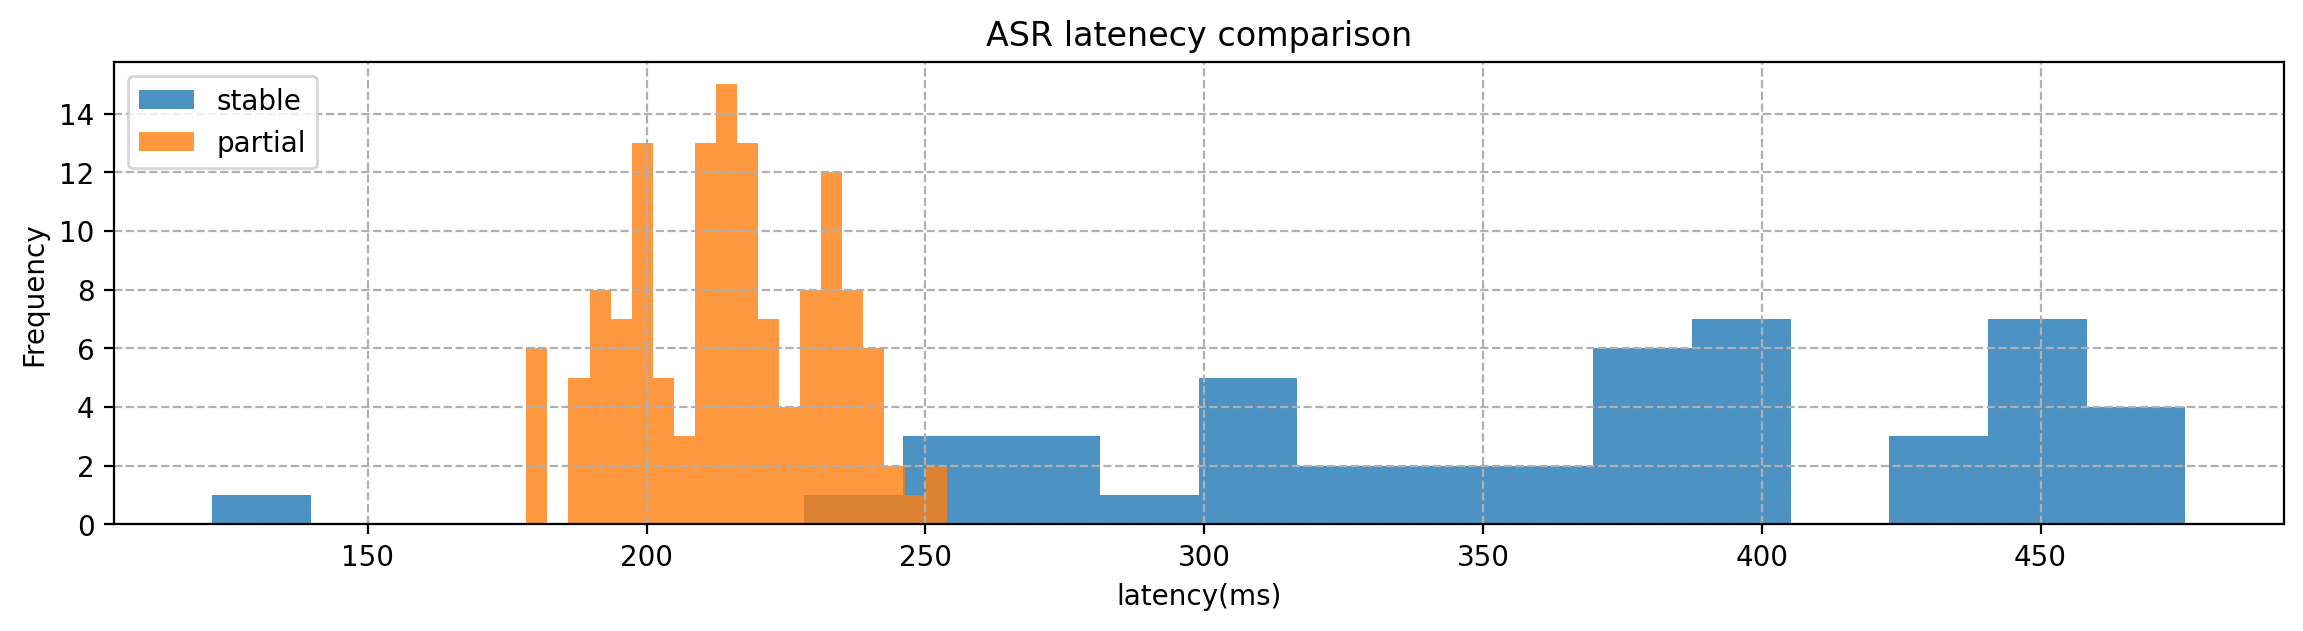

In [33]:
fig, ax = plt.subplots(figsize = (14,3))
stable_results['partial_latency'].hist(bins = 20, label = 'stable', alpha = 0.8)
partial_results['partial_latency'].hist(bins = 20, label = 'partial', alpha = 0.8)

plt.legend(loc = 'upper left')
plt.title("ASR latenecy comparison")
plt.xlabel("latency(ms)")
plt.ylabel("Frequency")
plt.grid(linestyle = '--')
plt.show()

经过统计，非稳态的延迟在250ms以下，稳态的延迟在500ms以下，说明当前的延迟在可接受范围内

ASR 450ms turntaking 350ms llm 500ms tts 500

In [20]:
450 + 350 + 500 + 500

1800

In [25]:
temp = concat_df.head(500)
temp[temp.action_type == 'recv']

,action_type,timestamp,iid,relative_time,chunk_index,expected_time,send_latency,slice_type,start_time,end_time,voice_text_str,data
89,recv,42541.906687,8d1f8690-0eef-4a40-83ea-9a9d7e232290,3546.575750,NaN,NaN,NaN,0.0,2820.0,3420.0,嗯,NaN
94,recv,42542.078949,8d1f8690-0eef-4a40-83ea-9a9d7e232290,3718.837916,NaN,NaN,NaN,1.0,2820.0,3540.0,嗯,NaN
126,recv,42543.318012,8d1f8690-0eef-4a40-83ea-9a9d7e232290,4957.901583,NaN,NaN,NaN,2.0,2820.0,4700.0,嗯。,NaN
405,recv,42554.431439,8d1f8690-0eef-4a40-83ea-9a9d7e232290,16071.327916,NaN,NaN,NaN,0.0,15300.0,15900.0,对,NaN
411,recv,42554.639451,8d1f8690-0eef-4a40-83ea-9a9d7e232290,16279.340041,NaN,NaN,NaN,1.0,15300.0,16100.0,对,NaN
419,recv,42554.893423,8d1f8690-0eef-4a40-83ea-9a9d7e232290,16533.311666,NaN,NaN,NaN,1.0,15300.0,16340.0,对我,NaN
432,recv,42555.375957,8d1f8690-0eef-4a40-83ea-9a9d7e232290,17015.846291,NaN,NaN,NaN,1.0,15300.0,16820.0,对我是,NaN
439,recv,42555.614120,8d1f8690-0eef-4a40-83ea-9a9d7e232290,17254.008708,NaN,NaN,NaN,2.0,15300.0,17000.0,对，我是。,NaN


### 体感分析

In [16]:
recording = dfs[-3]
recording[recording.slice_type == 2]

,action_type,timestamp,iid,relative_time,chunk_index,expected_time,send_latency,slice_type,start_time,end_time,voice_text_str,data
82,recv,42707.739610,recording-origin,3105.000750,NaN,NaN,NaN,2.0,740.0,2680.0,你好，你好。,NaN
143,recv,42709.972385,recording-origin,5337.775375,NaN,NaN,NaN,2.0,2920.0,4940.0,今天你开心吗？,NaN
203,recv,42712.148832,recording-origin,7514.222375,NaN,NaN,NaN,2.0,4940.0,7160.0,你们公司有什么产品？,NaN
261,recv,42714.356735,recording-origin,9722.125292,NaN,NaN,NaN,2.0,7760.0,9600.0,你们公司是做金融的吗？,NaN


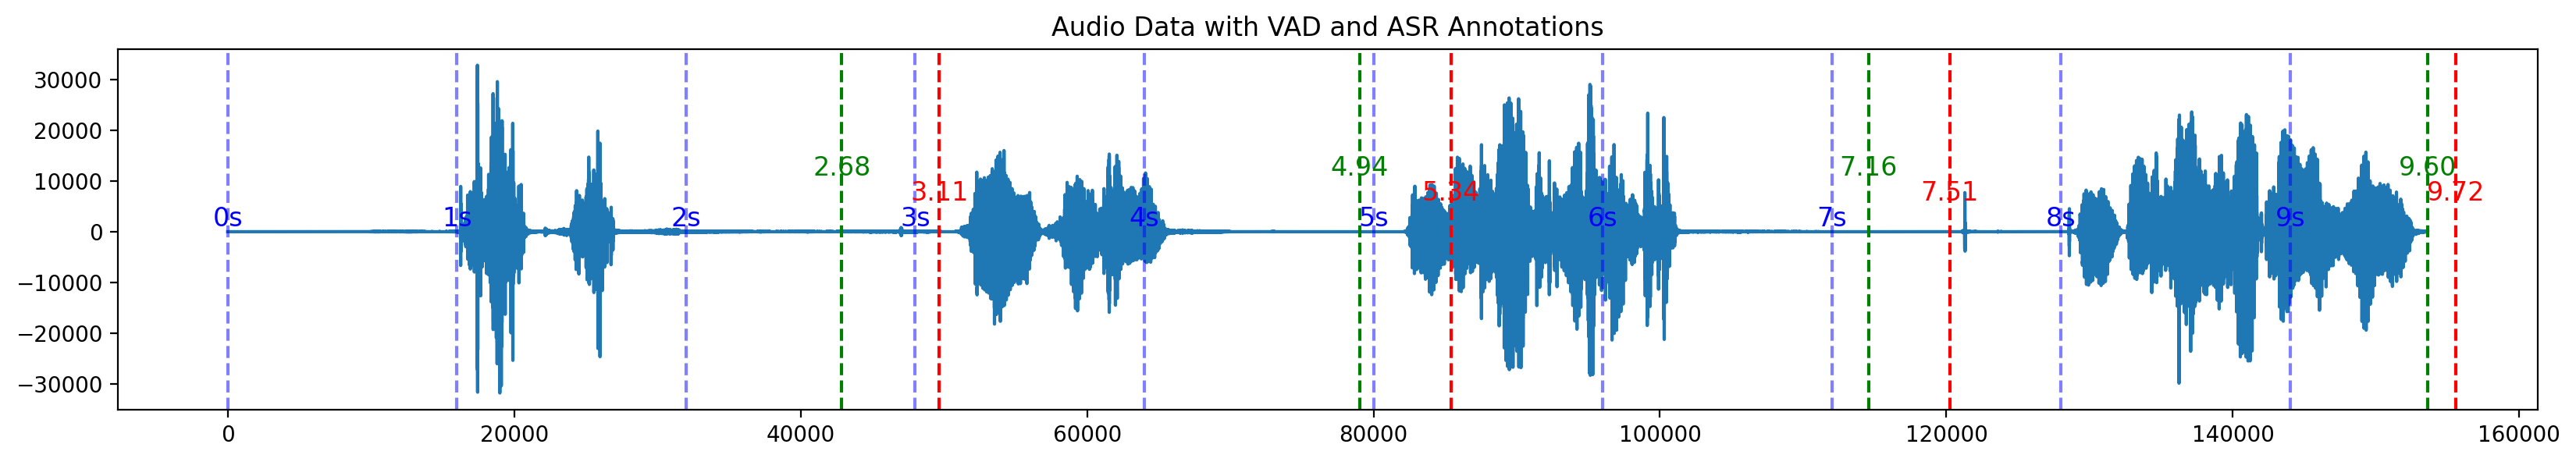

In [30]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'

file_path = "/Users/wanghuan/Projects/tecent-audio-testing/data/recording-origin.wav"
sampling_rate, audio_data = wavfile.read(file_path)

# Ensure the sampling rate is 16000
if sampling_rate != 16000:
    raise ValueError(f"Expected sampling rate of 16000, but got {sampling_rate}")

fig, ax = plt.subplots(figsize=(20, 3))
vlines = np.array([3105.0007500016363,5337.7753750028205,7514.222375000827,9722.125291998964]) / 1000
vlines2 = [2.68, 4.94, 7.16, 9.6]
plt.plot(audio_data)
for l in vlines:
    plt.axvline(x=l * 16000, color='r', linestyle='--')
    plt.text(l * 16000, 5000, f"{l:.2f}", color='r', fontsize=12, ha='center', va='bottom')
for i in range(10):
    plt.axvline(x=i * 16000, color='b', linestyle='--', alpha = 0.5)
    plt.text(i * 16000, 0, f"{i}s", color='b', fontsize=12, ha='center', va='bottom')
for l in vlines2:
    plt.axvline(x=l * 16000, color='g', linestyle='--')
    plt.text(l * 16000, 10000, f"{l:.2f}", color='g', fontsize=12, ha='center', va='bottom')
# put a color label annotation, blue:actual seconds, red: receive time, green: vad time, just annotation is ok
plt.title("Audio Data with VAD and ASR Annotations")
plt.show()